# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [110]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [111]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [112]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

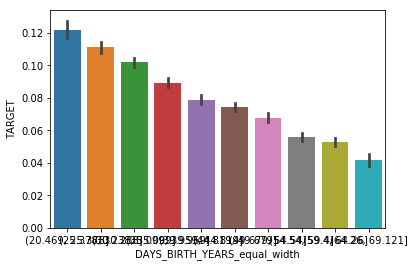

離散化前 [[ 1.         -0.07823931]
 [-0.07823931  1.        ]]
離散化後 [[ 1.        -0.0780294]
 [-0.0780294  1.       ]]
離散前準確率: 0.9192711805397202
離散後準確率: 0.9192711805397202


In [109]:
############## 等寬離散化 ##################

### 將 DAYS_BIRTH_YEARS 以歲數表示
app_train['DAYS_BIRTH_YEARS'] = abs(app_train['DAYS_BIRTH'])/365

### 將 DAYS_BIRTH_YEARS 做等寬離散化 ### 
app_train['DAYS_BIRTH_YEARS_equal_width'] = pd.cut(app_train['DAYS_BIRTH_YEARS'],bins = 10)
app_train['DAYS_BIRTH_YEARS_equal_width'].value_counts()

### 將app_train補一欄各組的DAYS_BIRTH_YEARS平均值
aaa = pd.DataFrame(app_train.groupby('DAYS_BIRTH_YEARS_equal_width')['DAYS_BIRTH_YEARS'].mean()).reset_index()
aaa.columns=['DAYS_BIRTH_YEARS_equal_width','DAYS_BIRTH_YEARS_Mean']
app_train = pd.merge(app_train,aaa, on = 'DAYS_BIRTH_YEARS_equal_width', how = 'left')

### 看離散化後與 TARGET 的長條圖
import seaborn as sns
sns.barplot(app_train['DAYS_BIRTH_YEARS_equal_width'] , app_train['TARGET'])
plt.show()

#######################################################
### 1. 比較離散化前後對 TARGET 解釋有無提升 (利用相關係數)

print('離散化前',np.corrcoef(app_train['DAYS_BIRTH_YEARS'],app_train['TARGET']))
print('離散化後',np.corrcoef(app_train['DAYS_BIRTH_YEARS_Mean'],app_train['TARGET']))

###  對 y 解釋度無明顯變化

########################################################
### 2. fit logisticregression 比較離散化前後有無改進 ###
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

### 離散前 ###
estimator = LogisticRegression()
cross_val_score(estimator, app_train[['DAYS_BIRTH_YEARS']], app_train['TARGET'], cv=5).mean()
print('離散前準確率:', cross_val_score(estimator, app_train[['DAYS_BIRTH_YEARS']], app_train['TARGET'], cv=5).mean())

### 離散後 ###
le = LabelEncoder()
app_train['DAYS_BIRTH_YEARS_equal_width'] = le.fit_transform(app_train['DAYS_BIRTH_YEARS_equal_width'])
estimator = LogisticRegression()
cross_val_score(estimator, app_train[['DAYS_BIRTH_YEARS_equal_width']], app_train['TARGET'], cv=5).mean()
print('離散後準確率:', cross_val_score(estimator, app_train[['DAYS_BIRTH_YEARS_equal_width']], app_train['TARGET'], cv=5).mean())
###   對 y 解釋度無明顯變化



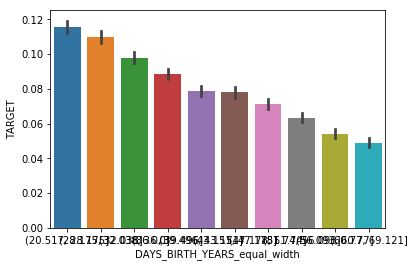

離散化前 [[ 1.         -0.07823931]
 [-0.07823931  1.        ]]
離散化後 [[ 1.         -0.07744173]
 [-0.07744173  1.        ]]
離散前準確率: 0.9192711805397202
離散後準確率: 0.9192711805397202


In [114]:
############## 等頻離散化 ##################

### 將 DAYS_BIRTH_YEARS 以歲數表示
app_train['DAYS_BIRTH_YEARS'] = abs(app_train['DAYS_BIRTH'])/365

### 將 DAYS_BIRTH_YEARS 做等頻離散化 ### 
app_train['DAYS_BIRTH_YEARS_equal_width'] = pd.qcut(app_train['DAYS_BIRTH_YEARS'],10)
app_train['DAYS_BIRTH_YEARS_equal_width'].value_counts()

### 將app_train補一欄各組的DAYS_BIRTH_YEARS平均值
aaa = pd.DataFrame(app_train.groupby('DAYS_BIRTH_YEARS_equal_width')['DAYS_BIRTH_YEARS'].mean()).reset_index()
aaa.columns=['DAYS_BIRTH_YEARS_equal_width','DAYS_BIRTH_YEARS_Mean']
app_train = pd.merge(app_train,aaa, on = 'DAYS_BIRTH_YEARS_equal_width', how = 'left')

### 看離散化後與 TARGET 的長條圖
import seaborn as sns
sns.barplot(app_train['DAYS_BIRTH_YEARS_equal_width'] , app_train['TARGET'])
plt.show()

##############################################################
### 1.  比較離散化前後對 TARGET 解釋有無提升 (利用相關係數)#####

print('離散化前',np.corrcoef(app_train['DAYS_BIRTH_YEARS'],app_train['TARGET']))
print('離散化後',np.corrcoef(app_train['DAYS_BIRTH_YEARS_Mean'],app_train['TARGET']))

### 對 y 解釋度無明顯變化


#############################################################
### 2. fit logisticregression 比較離散化前後有無改進 #########
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

### 離散前 ###
estimator = LogisticRegression()
cross_val_score(estimator, app_train[['DAYS_BIRTH_YEARS']], app_train['TARGET'], cv=5).mean()
print('離散前準確率:', cross_val_score(estimator, app_train[['DAYS_BIRTH_YEARS']], app_train['TARGET'], cv=5).mean())

### 離散後 ###
le = LabelEncoder()
app_train['DAYS_BIRTH_YEARS_equal_width'] = le.fit_transform(app_train['DAYS_BIRTH_YEARS_equal_width'])
estimator = LogisticRegression()
cross_val_score(estimator, app_train[['DAYS_BIRTH_YEARS_equal_width']], app_train['TARGET'], cv=5).mean()
print('離散後準確率:', cross_val_score(estimator, app_train[['DAYS_BIRTH_YEARS_equal_width']], app_train['TARGET'], cv=5).mean())
###  對 y 解釋度無明顯變化
